In [1]:
# pip install scikit-image
# pip install sewar
# pip install pydicom
# pip install opencv-python
# pip show pillow

In [1]:
import cv2
import random
import numpy as np
import pydicom as dicom
import matplotlib.pylab as plt
from math import dist
from skimage.draw import line
from numpy.fft import fft2, fftshift, fftn, ifftshift
from utils import radial_mask, frequency_mask, transform_image_to_kspace, \
    transform_kspace_to_image, compare_k, corrupt

In [3]:
# image space

image_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
#image_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\100099070170\308.dcm'
#image_path = r'C:\from SSD\fastMRI_brain_DICOM\381174253091\395.dcm' # error

ds = dicom.dcmread(image_path)
image = ds.pixel_array

if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

downsample = corrupt(np.copy(image), "downsample")
noise = corrupt(np.copy(image), "noise")
motion = corrupt(np.copy(image), "motion")

In [4]:
# k space

k = np.abs(transform_image_to_kspace(image))
k_downsample = np.abs(transform_image_to_kspace(downsample))
k_noise = np.abs(transform_image_to_kspace(noise))
k_motion = np.abs(transform_image_to_kspace(motion))

k = k / np.max(np.abs(k))
k_downsample = k_downsample / np.max(np.abs(k_downsample))
k_noise = k_noise / np.max(np.abs(k_noise))
k_motion = k_motion / np.max(np.abs(k_motion))

(-0.5, 319.5, 319.5, -0.5)

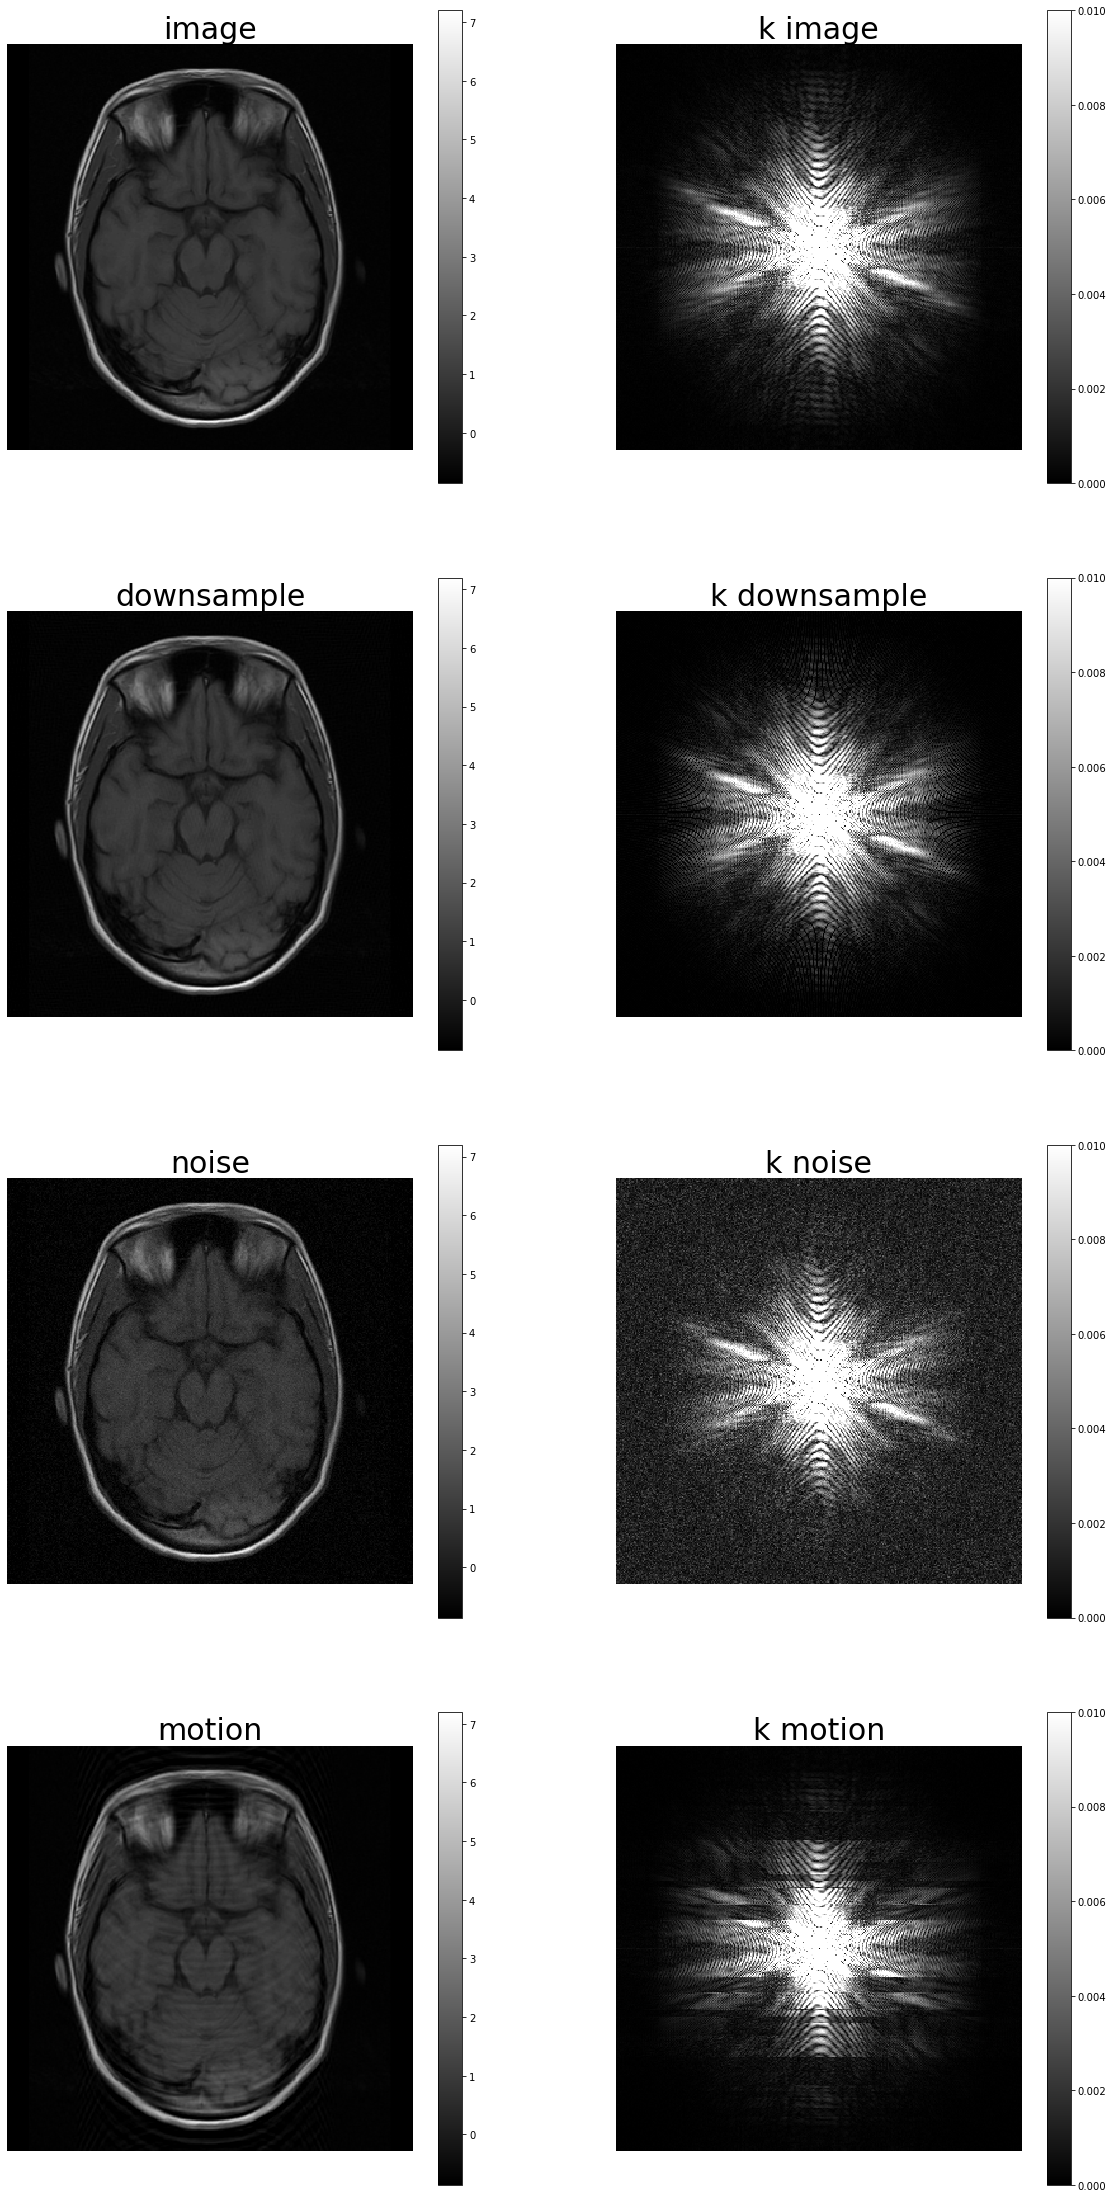

In [5]:
# visualization

vmx = np.max(image)
vmn = np.min(image)
dmx = 0.5
kmx = 0.01

plt.figure(figsize=(20, 40))

plt.subplot(4, 2, 1)
plt.title('image', fontsize=30)
plt.imshow(image, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 2)
plt.title('k image', fontsize=30)
plt.imshow(k, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 3)
plt.title('downsample', fontsize=30)
plt.imshow(downsample, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 4)
plt.title('k downsample', fontsize=30)
plt.imshow(k_downsample, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 5)
plt.title('noise', fontsize=30)
plt.imshow(noise, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 6)
plt.title('k noise', fontsize=30)
plt.imshow(k_noise, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 7)
plt.title('motion', fontsize=30)
plt.imshow(motion, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(4, 2, 8)
plt.title('k motion', fontsize=30)
plt.imshow(k_motion, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

(-0.5, 319.5, 319.5, -0.5)

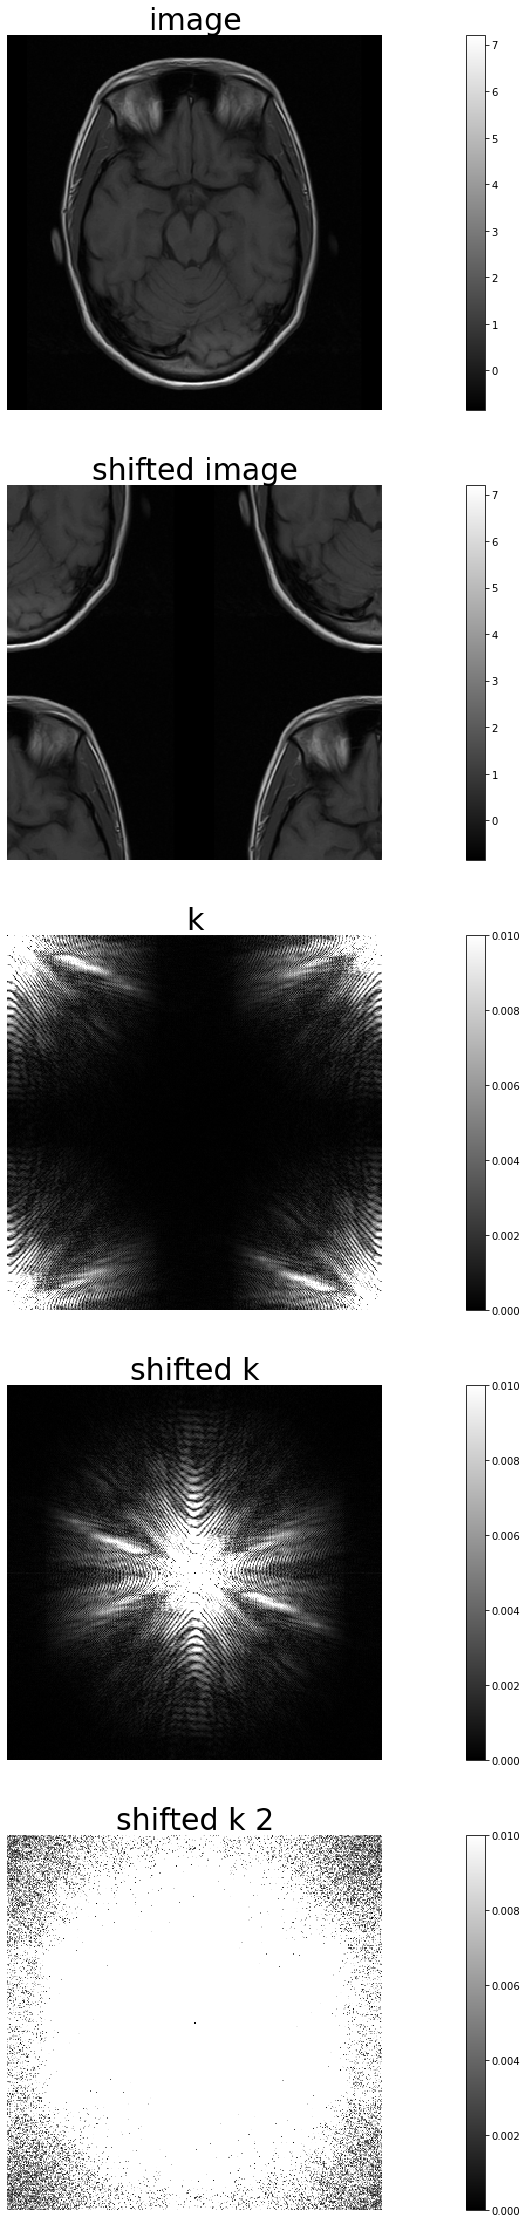

In [6]:
# steps of function 'transform_image_to_kspace(image)'

dim = range(image.ndim)

shifted_image = fftshift(image, axes=dim)

k_step = np.abs(fftn(shifted_image, s=None, axes=dim))
k_step_v = k_step / np.max(np.abs(k_step))

shifted_k = np.abs(ifftshift(k_step, axes=dim))
shifted_k_v = shifted_k / np.max(np.abs(shifted_k))

shifted_k_2 = shifted_k.copy()
shifted_k_2 /= np.sqrt(np.prod(np.take(image.shape, dim)))

plt.figure(figsize=(30, 40))

plt.subplot(5, 1, 1)
plt.title('image', fontsize=30)
plt.imshow(image, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(5, 1, 2)
plt.title('shifted image', fontsize=30)
plt.imshow(shifted_image, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(5, 1, 3)
plt.title('k', fontsize=30)
plt.imshow(k_step_v, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

plt.subplot(5, 1, 4)
plt.title('shifted k', fontsize=30)
plt.imshow(shifted_k_v, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

plt.subplot(5, 1, 5)
plt.title('shifted k 2', fontsize=30)
plt.imshow(shifted_k_2, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

In [7]:
def frequency_mask(thr, horizontal, extra):
    
    size = 320
    mask = np.zeros((size, size), dtype=np.bool)
    band = int(320 / thr)

    if (horizontal):
        mask[:, int((size - band - 2) / 2):int((size + band - 2) / 2)] = True
    else:
        mask[int((size - band - 2) / 2):int((size + band - 2) / 2), :] = True

    if (extra):
        for i in range(int(size / thr)):
            if (horizontal):
                mask[:, np.random.randint(0, 320)] = True
            else:
                mask[np.random.randint(0, 320), :] = True

    return mask

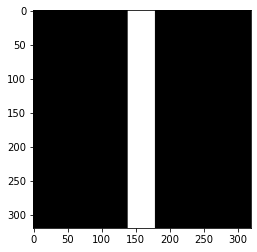

In [8]:
# mask = frequency_mask(random.choice([2, 4, 8]), random.choice([True, False]), random.choice([False]))
thr = random.choice([2, 4, 8])
horizontal = random.choice([True, False])
extra = random.choice([True, False])

size = 320
mask = np.zeros((size, size), dtype=bool)
band = int(320 / thr)

if (horizontal):
    mask[:, int((size - band - 2) / 2):int((size + band - 2) / 2)] = True
else:
    mask[int((size - band - 2) / 2):int((size + band - 2) / 2), :] = True

if (extra):
    for i in range(int(size / thr)):
        if (horizontal):
            mask[:, np.random.randint(0, 320)] = True
        else:
            mask[np.random.randint(0, 320), :] = True

plt.imshow(mask, cmap='gist_gray')

In [9]:
def radial_mask(thr):
    size = 320
    mask = np.zeros((size, size), dtype=np.bool)
    for i in range(0, size + 1, thr):
        img = np.zeros((size, size), dtype=np.float32)
        nmb = i
        for j in range(2):
            if (j == 1):
                rr, cc = line(0, nmb, size, size - nmb)
            else:
                rr, cc = line(nmb, 0, size - nmb, size)

            cc = cc[rr < size]
            rr = rr[rr < size]

            rr = rr[cc < size]
            cc = cc[cc < size]
            img[rr, cc] = 1
            mask = mask | (img > 0)
        
    return mask

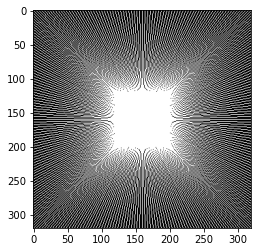

In [10]:
# mask = radial_mask(random.choice([2, 4, 8]))
thr = random.choice([2, 4, 8])

size = 320
mask = np.zeros((size, size), dtype=bool)
for i in range(0, size + 1, thr):
    img = np.zeros((size, size), dtype=np.float32)
    nmb = i
    for j in range(2):
        if (j == 1):
            rr, cc = line(0, nmb, size, size - nmb)
        else:
            rr, cc = line(nmb, 0, size - nmb, size)
        
        cc = cc[rr < size]
        rr = rr[rr < size]

        rr = rr[cc < size]
        cc = cc[cc < size]
        img[rr, cc] = 1
        mask = mask | (img > 0)
            
plt.imshow(mask, cmap='gist_gray')

In [11]:
def corrupt(image, case):
    
    kspace = transform_image_to_kspace(image)

    if case == "downsample":
        approach = random.choice(["cartesian", "radial"])
        if (approach == "cartesian"):
            mask = frequency_mask(random.choice([2, 4, 8]), random.choice([True, False]), random.choice([False]))
        elif (approach == "radial"):
            mask = radial_mask(random.choice([2, 4, 8]))

        kspace = np.where(mask, kspace, (0 + 0j))
    elif case == "noise":
        mag = np.random.uniform(0.1, 0.2)
        img = transform_kspace_to_image(kspace)
        img = (img - np.mean(img)) / np.std(img)
        kspace = transform_image_to_kspace(img + np.random.normal(0, mag, size=np.shape(kspace)))
    elif case == "motion":
        mag = random.choice([5]) # so always 5
        k = np.zeros_like(transform_image_to_kspace(kspace)) # unnnecessary step; makes zeros array of (320, 320)
        for i in range(np.shape(k)[0]):
            if ((i > 180) & (random.random() < (1 / mag))):
                kspace = np.roll(kspace, random.randint(-8, 8), 0)
            k[i, :] = kspace[i, :]
        kspace = k
    
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)

    return img#np.stack([np.real(kspace), np.imag(kspace)], 2)

(-0.5, 319.5, 319.5, -0.5)

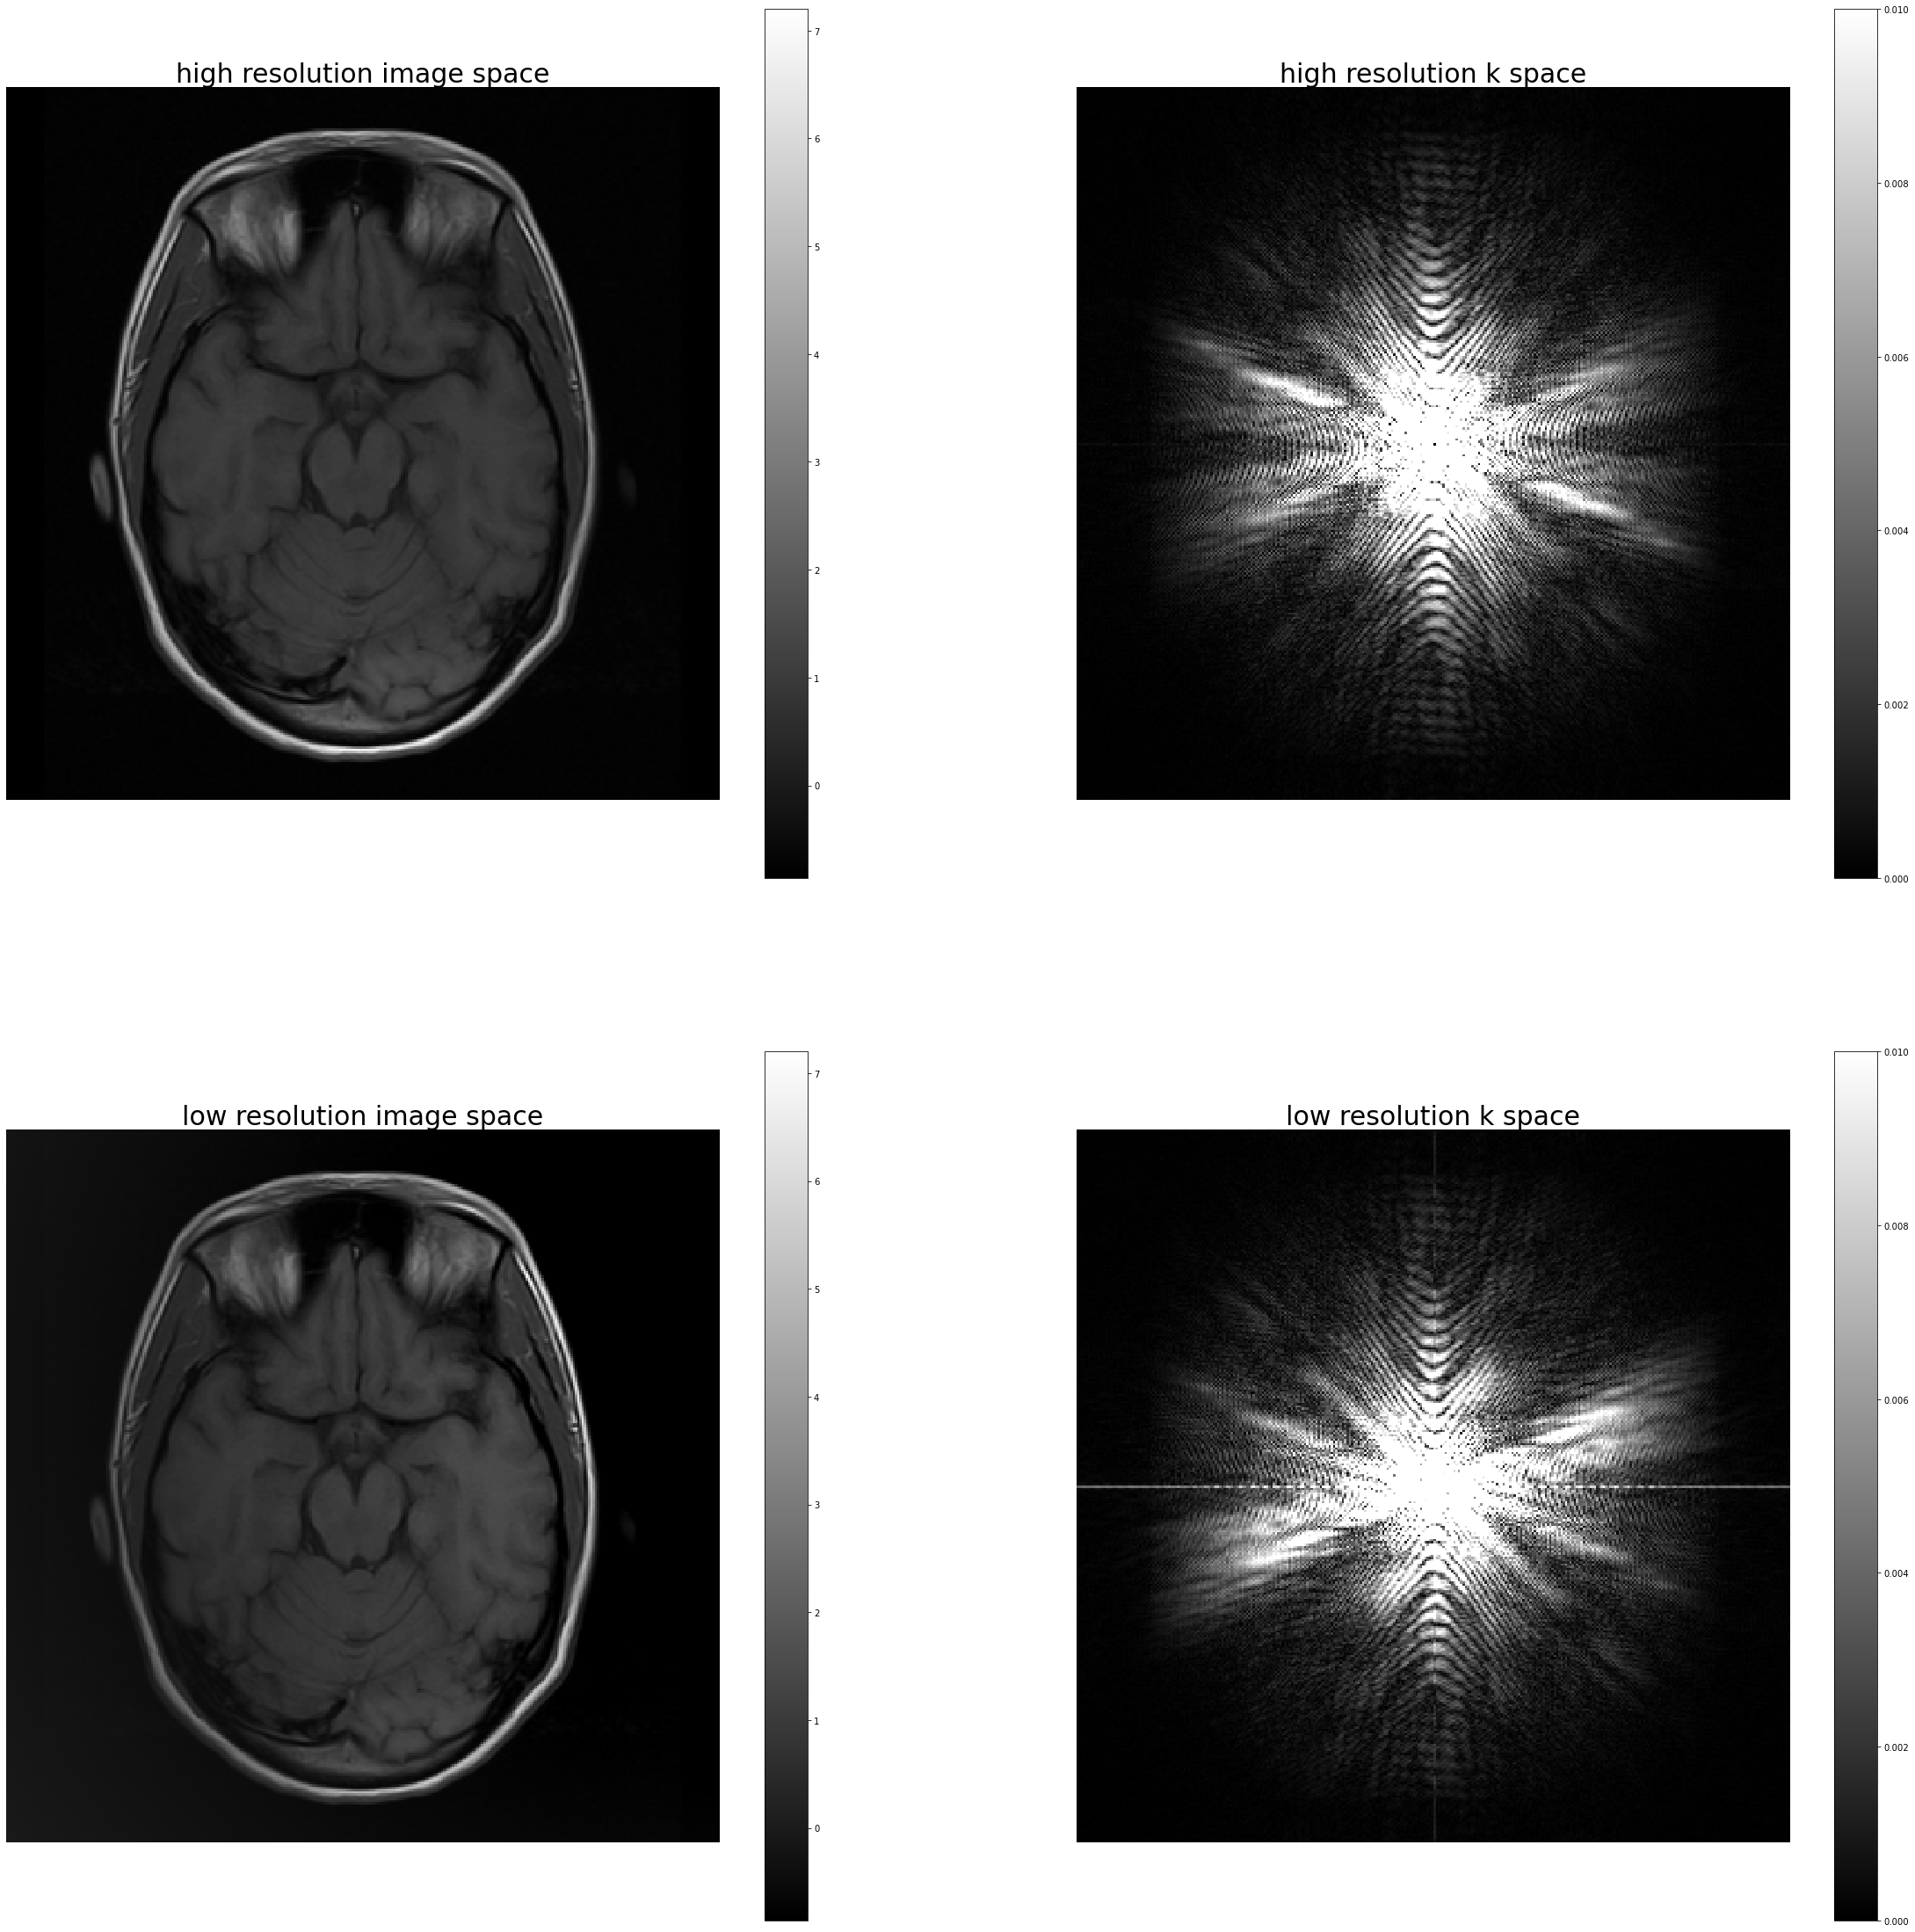

In [12]:
kspace = transform_image_to_kspace(image)
k_hr = np.abs(kspace)
k_hr = k_hr / np.max(k_hr)

#case = random.choice(["downsample", "noise", "motion"])
case = random.choice(["bias"])

if case == "downsample":
    approach = random.choice(["cartesian", "radial"])
    if (approach == "cartesian"):
        mask = frequency_mask(random.choice([2, 4, 8]), random.choice([True, False]), random.choice([True, False]))
    elif (approach == "radial"):
        mask = radial_mask(random.choice([2, 4, 8]))     
    kspace = np.where(mask, kspace, (0 + 0j))
    
elif case == "noise":
    mag = np.random.uniform(0.1, 0.2)
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    kspace = transform_image_to_kspace(img + np.random.normal(0, mag, size=np.shape(kspace)))
                                       
elif case == "motion":
    mag = random.choice([5])
    k = np.zeros_like(transform_image_to_kspace(kspace))
    for i in range(np.shape(k)[0]):
        if ((i > 180) & (random.random() < (1 / mag))):
            kspace = np.roll(kspace, random.randint(-8, 8), 0)
        k[i, :] = kspace[i, :]
    kspace = k

elif case == "bias":
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    
    size = 320
    bias = np.zeros((size, size), dtype=np.float32)
    
    approach = random.choice(["circular"])
    
    if (approach == "straight"):
        direction = random.choice(["horizontal", "vertical"])
        for i in range(size):
            if (direction == "horizontal"):
                bias[i,:] = (i+1)/size
            elif (direction == "vertical"):
                bias[:,i] = (i+1)/size
        flip = random.choice([True, False])
        if (flip):
            bias = abs(1-bias)
            
    elif (approach == "circular"):
        i = random.randint(0, 320)
        j = random.randint(0, 320)
        corners = [[0,0],[0,319],[319,0],[319,319]]
        dis = []
        for k in corners:
            dis.append(dist((i,j), k))
        dist_max = max(dis)
        for l in range(320):
            for m in range(320):
                bias[l,m] = 1 - (dist((i,j),(l,m))/dist_max)
    
    img = img*bias
    kspace = transform_image_to_kspace(img)
    
k_lr = np.abs(kspace)
k_lr = k_lr / np.max(k_lr)

img = transform_kspace_to_image(kspace)
img = (img - np.mean(img)) / np.std(img)

plt.figure(figsize=(40, 40))

plt.subplot(2, 2, 1)
plt.title('high resolution image space', fontsize=30)
plt.imshow(image, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('high resolution k space', fontsize=30)
plt.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('low resolution image space', fontsize=30)
plt.imshow(img, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('low resolution k space', fontsize=30)
plt.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

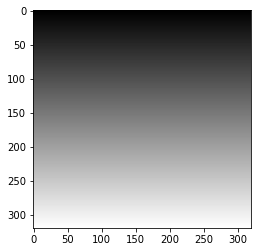

In [13]:
# bias
size = 320
bias = np.zeros((size, size), dtype=np.float32)
for i in range(size):
    bias[i,:] = (i+1)/size
plt.imshow(bias, cmap='gist_gray')

(-0.5, 319.5, 319.5, -0.5)

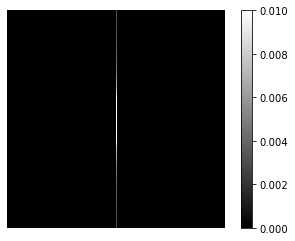

In [14]:
k_bias = np.abs(transform_image_to_kspace(bias))
k_bias = k_bias / np.max(np.abs(k_bias))
plt.imshow(k_bias, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

(-0.5, 319.5, 319.5, -0.5)

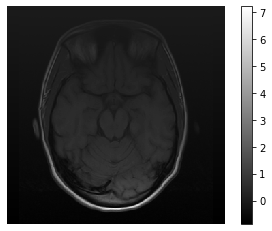

In [15]:
image_bias = image*bias
plt.imshow(image_bias, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

(-0.5, 319.5, 319.5, -0.5)

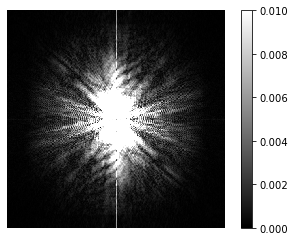

In [16]:
kspace_bias = transform_image_to_kspace(image_bias)
kspace_bias = np.abs(kspace_bias)
kspace_bias = kspace_bias / np.max(kspace_bias)
plt.imshow(kspace_bias, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

(-0.5, 319.5, 319.5, -0.5)

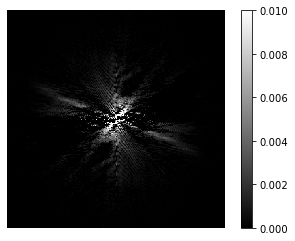

In [17]:
diff = k_hr - k_lr
plt.imshow(diff, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
plt.colorbar()
plt.axis('off')

(-0.5, 319.5, 319.5, -0.5)

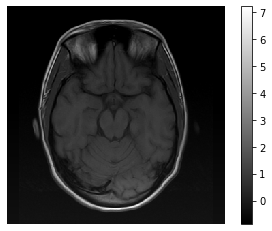

In [18]:
k1 = transform_image_to_kspace(image)
k2 = transform_image_to_kspace(bias)
ktot = k1+k2
imgtot = transform_kspace_to_image(ktot)
imgtot = (imgtot - np.mean(imgtot)) / np.std(imgtot)
plt.imshow(imgtot, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
plt.colorbar()
plt.axis('off')

(-0.5, 319.5, 319.5, -0.5)

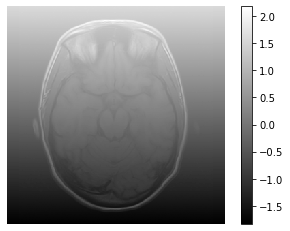

In [19]:
imgdiff = image - imgtot
imgdiff = (imgdiff - np.mean(imgdiff)) / np.std(imgdiff)
plt.imshow(imgdiff, interpolation='none', cmap='gist_gray')
plt.colorbar()
plt.axis('off')

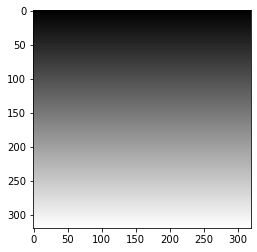

In [20]:
size = 320
bias = np.zeros((size, size), dtype=np.float32)
for i in range(size):
    bias[i,:] = i/(size-1)
plt.imshow(bias, interpolation='none', cmap='gist_gray')

In [ ]:
# unused noise functions

# method Attila = adds Gaussian noise to image space    
#def add_noise_1(kspace):    
#    #mag = np.random.uniform(0.1, 0.2)
#    mag = 0.2
#    print(mag)
#    img = transform_kspace_to_image(kspace)
#    img = (img - np.mean(img)) / np.std(img)
#    kspace = transform_image_to_kspace(img + np.random.normal(0, mag, size=np.shape(kspace)))
#    return kspace

# method k space explorer = adds noise in decibel to k space
#def add_noise_2(kspace):
#    signal_to_noise = random.randint(19, 20) #TODO: find common SNR values in literature
#    print(signal_to_noise)
#    mean_signal = np.mean(np.abs(kspace))
#    std_noise = mean_signal / np.power(10, (signal_to_noise / 20)) # SNR [dB] = 20log10(S/N)
#    print(std_noise)
#    noise = std_noise * (np.random.randn(*kspace.shape))
#    kspace += noise
#    return kspace

# method self = adds Complex Gaussian noise with sd related to max pixel value
#def add_noise_3(kspace):
#    mag = np.random.uniform(0.002, 0.0025)
#    mag_real = mag*np.max(np.real(kspace)) # doesn't work well because of outliers in kspace data
#    mag_imag = mag*np.max(np.imag(kspace))
#    noise = np.random.normal(0, mag_real, size=np.shape(kspace)) + 1j*np.random.normal(0, mag_imag, size=np.shape(kspace))
#    kspace += noise
#    return kspace

# method self = adds Complex Gaussian noise with predefined sd
#def add_noise_4(kspace):
#    #mag = np.random.uniform(0.4, 0.5)
#    mag = 0.2
#    noise = np.random.normal(0, mag, size=np.shape(kspace)) + 1j*np.random.normal(0, mag, size=np.shape(kspace))
#    kspace += noise
#    return kspace

# method self = adds Complex Gaussian noise in decibel to k-space
# https://github.com/mmuckley/dldegibbs/blob/master/data/transforms/mrinoise.py
#def add_noise_5(kspace):
#    snr_range = (0, 1)
#    cur_snr = 2**(np.random.uniform(snr_range[0], snr_range[1]))
#    print(cur_snr)
#    siglevel = np.mean(np.abs(kspace))
#    sigma = siglevel / cur_snr
#    print(sigma)
#    kspace += sigma*(np.random.normal(size=kspace.shape) + 1j*np.random.normal(size=kspace.shape))
#    return kspace

In [ ]:
# reduced_scan_percentage = sampling truncation --> Gibbs ringing
#def reduced_scan_percentage(kspace):
#    percentage = random.randint(50, 100)
#    if percentage < 100:
#        percentage_delete = 1 - percentage / 100
#        lines_to_delete = round(percentage_delete * kspace.shape[0] / 2)
#        if lines_to_delete:
#            approach = random.choice(["horizontal", "vertical"])
#            if (approach == "horizontal"):
#                kspace[0:lines_to_delete, :] = 0
#                kspace[-lines_to_delete:, :] = 0
#            elif (approach == "vertical"):
#                kspace[:, 0:lines_to_delete] = 0
#                kspace[:, -lines_to_delete:] = 0
#    return kspace

# undersample --> foldover/phase wrap-around artefacts
# rectangular field of view (RFOV) won't be used, since this compressed the kspace
# output needs to remain the same to train the KIKI model
#def undersample(kspace):
#    #factor = random.randint(1, 16)
#    factor = 2
#    if factor > 1:
#        mask = np.ones(kspace.shape, dtype=bool)
#        midline = kspace.shape[0] // 2
#        approach = random.choice(["horizontal", "vertical"])
#        if (approach == "horizontal"):
#            mask[midline::factor, :] = 0
#            mask[midline::-factor, :] = 0
#        elif (approach == "vertical"):
#            mask[:, midline::factor] = 0
#            mask[:, midline::-factor] = 0
#        kspace[mask] = 0
        
#    return kspace

#TODO: replace with method that keeps the middle lines
#TODO: add various filling methods

# partial_fourier
#def partial_fourier(kspace):
#    percentage = random.randint(0, 50)
#    print(percentage)
#    zf = random.choice([True, False])
#    flip = random.choice([True, False])
#    approach = random.choice(["horizontal", "vertical"])
#    if percentage != 100:
#        percentage = 1 - percentage / 100
#        rows_to_skip = round(percentage * (kspace.shape[0] / 2 - 1))
#        if rows_to_skip and zf: # lines not acquired are filled with zeros
#            kspace[-rows_to_skip:] = 0
#        elif rows_to_skip:
#            kspace[-rows_to_skip:] = \
#                np.roll(kspace[::-1, ::-1], shift=(1, 1), axis=(0, 1))[-rows_to_skip:]            
#            np.conj(kspace[-rows_to_skip:], kspace[-rows_to_skip:]) # Conjugate replaced lines
#    return kspace

# TODO: add horizontal/vertical approach, and flip

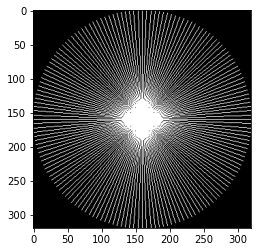

In [41]:
# mask = radial_mask(random.choice([2, 4, 8]))
thr = random.choice([2])

size = 320
r = round(size/2)
mask = np.zeros((size, size), dtype=bool)
for i in range(0, size + 1, thr):
    img = np.zeros((size, size), dtype=np.float32)
    angle = i/size * (2*np.pi)
    r1 = round(r*np.cos(angle))
    c1 = round(r*np.sin(angle))
    rr, cc = line(r, r, r+r1, r+c1) #(r0, c0, r1, c1)
    
    cc = cc[rr < size]
    rr = rr[rr < size]

    rr = rr[cc < size]
    cc = cc[cc < size]
    img[rr, cc] = 1
    mask = mask | (img > 0)
            
plt.imshow(mask, cmap='gist_gray')

In [53]:
w = 6.25 # 8/64 * 50 = 6.25 which means we have 6.25 turns aka windings
numProfiles = 2
numSamplingPerProfile = 10
kmax = 0.5
for l in range(numProfiles):
    for k in range (numSamplingPerProfile):
        t = np.sqrt(((k+1)-1)/(numSamplingPerProfile-1))
        nodes = np.zeros((2, size, size), dtype=np.float32)
        nodes[1,k,l] = kmax*t*np.cos(2*np.pi*( w*t + angles[l] ))
#        nodes[2,k,l] = kmax*t*sin(2*pi*( w*t + angles[l] ))
#    end
#nd

#mask = reshape(nodes, 2, numSamplingPerProfile*numProfiles)


NameError: name 'angles' is not defined

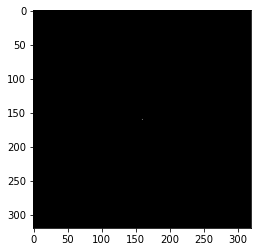

In [60]:
# mask = radial_mask(random.choice([2, 4, 8]))
#thr = random.choice([2])

size = 320
r = round(size/2)
angle = 0
mask = np.zeros((size, size), dtype=bool)
steps = 100
for i in range(steps):
    img = np.zeros((size, size), dtype=np.float32)
    angle = i/steps * (10*np.pi)
    r = i/steps * r
    r1 = 160+round(r*np.cos(angle))
    c1 = 160+round(r*np.sin(angle))
    img[r1, c1] = 1
    mask = mask | (img > 0)
    #r = r + (1/steps)*r
    #angle = angle + (1/steps)*2*np.pi
            
plt.imshow(mask, cmap='gist_gray')